# Bước 6: Phân cụm khách hàng từ Luật kết hợp (Association Rules → Clustering)

Notebook này lấy **kết quả luật kết hợp** (Apriori/FP-Growth) và biến chúng thành **đặc trưng** để phân cụm khách hàng bằng K-Means.

## Ý tưởng cốt lõi
- Mỗi luật có dạng: **Antecedent → Consequent**
- Với mỗi khách hàng, ta kiểm tra: khách đó đã từng mua **đủ antecedents** của luật hay chưa.
- Mỗi luật trở thành một feature (0/1 hoặc có trọng số theo lift/confidence).
- (Tuỳ chọn) Ghép thêm **RFM** để phân cụm ổn định hơn.


## Parameters
Gán tham số để chạy bằng papermill.


In [4]:
# PARAMETERS (for papermill)
import os

# Determine project root (works whether running from notebooks/ or project root)
_cwd = os.getcwd()
if os.path.basename(_cwd) == "notebooks":
    _project_root = os.path.abspath("..")
else:
    _project_root = _cwd

# Input
CLEANED_DATA_PATH = os.path.join(_project_root, "data/processed/cleaned_uk_data.csv")
RULES_INPUT_PATH = os.path.join(_project_root, "data/processed/rules_apriori_filtered.csv")  # hoặc rules_fpgrowth_filtered.csv

# Feature engineering
TOP_K_RULES = 200
SORT_RULES_BY = "lift"      # lift | confidence | support
WEIGHTING = "lift"          # none | lift | confidence | support | lift_x_conf
MIN_ANTECEDENT_LEN = 1
USE_RFM = True
RFM_SCALE = True
RULE_SCALE = False

# Clustering
K_MIN = 2
K_MAX = 10
N_CLUSTERS = None            # None => chọn theo silhouette, hoặc đặt số cụ thể (vd 5)
RANDOM_STATE = 42

# Output
OUTPUT_CLUSTER_PATH = os.path.join(_project_root, "data/processed/customer_clusters_from_rules.csv")

# Visual
PROJECTION_METHOD = "pca"   # pca | svd
PLOT_2D = True

print(f"Project root: {_project_root}")
print(f"Cleaned data: {CLEANED_DATA_PATH}")
print(f"Rules input: {RULES_INPUT_PATH}")

Project root: c:\Coding\DataMining\ThucHanh\Cluster\Nhom_12_Cluster
Cleaned data: c:\Coding\DataMining\ThucHanh\Cluster\Nhom_12_Cluster\data/processed/cleaned_uk_data.csv
Rules input: c:\Coding\DataMining\ThucHanh\Cluster\Nhom_12_Cluster\data/processed/rules_apriori_filtered.csv


## Set up


In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Determine correct project root
cwd = os.getcwd()
if os.path.basename(cwd) == "notebooks":
    project_root = os.path.abspath("..")
else:
    project_root = cwd

src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

from cluster_library import RuleBasedCustomerClusterer


## Load cleaned data & rules


In [5]:
df_clean = pd.read_csv(CLEANED_DATA_PATH, parse_dates=["InvoiceDate"])
print(df_clean.shape)
df_clean.head()


(485123, 11)


C:\Users\HOANGANH\AppData\Local\Temp\ipykernel_13196\4012976299.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_clean = pd.read_csv(CLEANED_DATA_PATH, parse_dates=["InvoiceDate"])


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,DayOfWeek,HourOfDay
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,017850,United Kingdom,15.30,2,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,017850,United Kingdom,20.34,2,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,017850,United Kingdom,22.00,2,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,017850,United Kingdom,20.34,2,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,017850,United Kingdom,20.34,2,8


In [6]:
clusterer = RuleBasedCustomerClusterer(df_clean=df_clean)
customer_item_bool = clusterer.build_customer_item_matrix(threshold=1)
print('Customer × Item:', customer_item_bool.shape)

rules_df = clusterer.load_rules(
    rules_csv_path=RULES_INPUT_PATH,
    top_k=TOP_K_RULES,
    sort_by=SORT_RULES_BY,
)
print('Rules used:', rules_df.shape)
rules_df.head()


Customer × Item: (3921, 4007)
Rules used: (200, 17)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,antecedents_str,consequents_str,rule_str
0,"frozenset({'HERB MARKER PARSLEY', 'HERB MARKER...",frozenset({'HERB MARKER THYME'}),0.011487,0.012763,0.010932,0.951691,74.567045,1.0,0.010785,20.435808,0.998053,0.820833,0.951066,0.904106,"HERB MARKER PARSLEY, HERB MARKER ROSEMARY",HERB MARKER THYME,"HERB MARKER PARSLEY, HERB MARKER ROSEMARY → HE..."
1,"frozenset({'HERB MARKER MINT', 'HERB MARKER TH...",frozenset({'HERB MARKER ROSEMARY'}),0.011098,0.012818,0.010599,0.955000,74.502403,1.0,0.010456,21.937369,0.997650,0.795833,0.954416,0.890920,"HERB MARKER MINT, HERB MARKER THYME",HERB MARKER ROSEMARY,"HERB MARKER MINT, HERB MARKER THYME → HERB MAR..."
2,"frozenset({'HERB MARKER MINT', 'HERB MARKER TH...",frozenset({'HERB MARKER PARSLEY'}),0.011098,0.012652,0.010432,0.940000,74.297105,1.0,0.010292,16.455802,0.997612,0.783333,0.939231,0.882281,"HERB MARKER MINT, HERB MARKER THYME",HERB MARKER PARSLEY,"HERB MARKER MINT, HERB MARKER THYME → HERB MAR..."
3,"frozenset({'HERB MARKER PARSLEY', 'HERB MARKER...",frozenset({'HERB MARKER ROSEMARY'}),0.011487,0.012818,0.010932,0.951691,74.244244,1.0,0.010784,20.434660,0.997995,0.817427,0.951064,0.902252,"HERB MARKER PARSLEY, HERB MARKER THYME",HERB MARKER ROSEMARY,"HERB MARKER PARSLEY, HERB MARKER THYME → HERB ..."
4,"frozenset({'HERB MARKER THYME', 'HERB MARKER B...",frozenset({'HERB MARKER ROSEMARY'}),0.011265,0.012818,0.010710,0.950739,74.169983,1.0,0.010565,20.039787,0.997757,0.800830,0.950099,0.893118,"HERB MARKER BASIL, HERB MARKER THYME",HERB MARKER ROSEMARY,"HERB MARKER BASIL, HERB MARKER THYME → HERB MA..."


## Build features (Rules → Features) + (optional) RFM


## Choose K (silhouette)


## Multi-Variant Feature Comparison

We will test different feature engineering strategies and compare their clustering quality.



In [7]:
# Define feature variants to test
variants = [
    {
        'name': 'Baseline: Binary Rules Only',
        'weighting': 'none',
        'use_rfm': False,
        'rfm_scale': False,
        'rule_scale': False,
        'top_k': 200,
    },
    {
        'name': 'Weighted Rules (Lift)',
        'weighting': 'lift',
        'use_rfm': False,
        'rfm_scale': False,
        'rule_scale': False,
        'top_k': 200,
    },
    {
        'name': 'Weighted Rules + RFM',
        'weighting': 'lift',
        'use_rfm': True,
        'rfm_scale': True,
        'rule_scale': False,
        'top_k': 200,
    },
    {
        'name': 'Weighted Rules + RFM (Scaled Rules)',
        'weighting': 'lift',
        'use_rfm': True,
        'rfm_scale': True,
        'rule_scale': True,
        'top_k': 200,
    },
    {
        'name': 'Binary Rules + RFM (Baseline variant)',
        'weighting': 'none',
        'use_rfm': True,
        'rfm_scale': True,
        'rule_scale': False,
        'top_k': 200,
    },
]

# Store results
variant_results = []

print("=" * 80)
print("MULTI-VARIANT CLUSTERING COMPARISON")
print("=" * 80)

for idx, variant in enumerate(variants, 1):
    print(f"\n[{idx}/{len(variants)}] Testing: {variant['name']}")
    print("-" * 80)
    
    # Reload rules for each variant (ensure clean state)
    rules_df_var = clusterer.load_rules(
        rules_csv_path=RULES_INPUT_PATH,
        top_k=variant['top_k'],
        sort_by=SORT_RULES_BY,
    )
    
    # Build features with variant config
    X_var, meta_var = clusterer.build_final_features(
        weighting=variant['weighting'],
        use_rfm=variant['use_rfm'],
        rfm_scale=variant['rfm_scale'],
        rule_scale=variant['rule_scale'],
        min_antecedent_len=MIN_ANTECEDENT_LEN,
    )
    
    print(f"  Feature matrix shape: {X_var.shape}")
    
    # Choose K by silhouette
    sil_df_var = clusterer.choose_k_by_silhouette(
        X_var,
        k_min=K_MIN,
        k_max=K_MAX,
        random_state=RANDOM_STATE,
    )
    
    best_k_var = int(sil_df_var.loc[0, 'k'])
    best_sil_var = float(sil_df_var.loc[0, 'silhouette'])
    
    print(f"  Best K: {best_k_var} (silhouette: {best_sil_var:.4f})")
    
    # Fit KMeans
    labels_var = clusterer.fit_kmeans(X_var, n_clusters=best_k_var, random_state=RANDOM_STATE)
    
    # Cluster size distribution
    unique, counts = np.unique(labels_var, return_counts=True)
    min_cluster_size = counts.min()
    max_cluster_size = counts.max()
    avg_cluster_size = counts.mean()
    
    print(f"  Cluster sizes: min={min_cluster_size}, max={max_cluster_size}, avg={avg_cluster_size:.1f}")
    
    # Store result
    variant_result = {
        'Variant': variant['name'],
        'Weighting': variant['weighting'],
        'Use RFM': variant['use_rfm'],
        'RFM Scale': variant['rfm_scale'],
        'Rule Scale': variant['rule_scale'],
        'Top K Rules': variant['top_k'],
        'Feature Dim': X_var.shape[1],
        'Best K': best_k_var,
        'Silhouette': best_sil_var,
        'Min Cluster Size': min_cluster_size,
        'Max Cluster Size': max_cluster_size,
        'Avg Cluster Size': avg_cluster_size,
        'X_data': X_var,
        'meta_data': meta_var,
        'labels': labels_var,
    }
    variant_results.append(variant_result)

print("\n" + "=" * 80)
print("VARIANT COMPARISON SUMMARY")
print("=" * 80)

comparison_df = pd.DataFrame([
    {k: v for k, v in r.items() if k not in ['X_data', 'meta_data', 'labels']}
    for r in variant_results
])
print(comparison_df.to_string())
print()


MULTI-VARIANT CLUSTERING COMPARISON

[1/5] Testing: Baseline: Binary Rules Only
--------------------------------------------------------------------------------
  Feature matrix shape: (3921, 200)
  Best K: 2 (silhouette: 0.7039)
  Cluster sizes: min=125, max=3796, avg=1960.5

[2/5] Testing: Weighted Rules (Lift)
--------------------------------------------------------------------------------
  Feature matrix shape: (3921, 200)
  Best K: 2 (silhouette: 0.8546)
  Cluster sizes: min=124, max=3797, avg=1960.5

[3/5] Testing: Weighted Rules + RFM
--------------------------------------------------------------------------------
  Feature matrix shape: (3921, 203)
  Best K: 2 (silhouette: 0.8541)
  Cluster sizes: min=124, max=3797, avg=1960.5

[4/5] Testing: Weighted Rules + RFM (Scaled Rules)
--------------------------------------------------------------------------------
  Feature matrix shape: (3921, 203)
  Best K: 2 (silhouette: 0.7358)
  Cluster sizes: min=124, max=3797, avg=1960.5

[5/5

In [8]:
# Select best variant based on silhouette score
best_variant_idx = comparison_df['Silhouette'].idxmax()
best_variant = variant_results[best_variant_idx]

print(f"\nBest variant (highest silhouette): {best_variant['Variant']}")
print(f"Silhouette score: {best_variant['Silhouette']:.4f}")

# Use best variant's data for final clustering
X_best = best_variant['X_data']
meta_best = best_variant['meta_data']
labels_best = best_variant['labels']
best_k = best_variant['Best K']

# Override if user specified N_CLUSTERS
if N_CLUSTERS is not None:
    best_k = int(N_CLUSTERS)
    print(f"\nUser override: Using K = {best_k}")
else:
    print(f"Using best K from silhouette: {best_k}")



Best variant (highest silhouette): Weighted Rules (Lift)
Silhouette score: 0.8546
Using best K from silhouette: 2


## Fit KMeans & save results


In [9]:
# Use the best variant's cluster labels (already computed during comparison)
meta_out = meta_best.copy()
meta_out['cluster'] = labels_best

# Ensure RFM columns are included if USE_RFM is True
if USE_RFM and 'Recency' not in meta_out.columns:
    # Recompute RFM if not in meta_best
    rfm_data = clusterer.compute_rfm()
    for col in ['Recency', 'Frequency', 'Monetary']:
        if col in rfm_data.columns and col not in meta_out.columns:
            meta_out = meta_out.merge(
                rfm_data[['CustomerID', col]], 
                on='CustomerID', 
                how='left'
            )

# Lưu
os.makedirs(os.path.dirname(OUTPUT_CLUSTER_PATH), exist_ok=True)
meta_out.to_csv(OUTPUT_CLUSTER_PATH, index=False)
print('Saved:', OUTPUT_CLUSTER_PATH)
print(f'Final clustering: {best_k} clusters, {len(meta_out)} customers')
print(f'Columns saved: {meta_out.columns.tolist()}')
meta_out.head(10)

Saved: c:\Coding\DataMining\ThucHanh\Cluster\Nhom_12_Cluster\data/processed/customer_clusters_from_rules.csv
Final clustering: 2 clusters, 3921 customers
Columns saved: ['CustomerID', 'cluster', 'Recency', 'Frequency', 'Monetary']


,CustomerID,cluster,Recency,Frequency,Monetary
0,000nan,1,1,1373,1716830.53
1,012346,0,326,1,77183.60
2,012747,0,2,11,4196.01
3,012748,1,1,209,33719.73
4,012749,0,4,5,4090.88
5,012820,0,3,4,942.34
6,012821,0,214,1,92.72
7,012822,0,71,2,948.88
8,012823,0,75,5,1759.50
9,012824,0,60,1,397.12


## Quick profiling


In [10]:
profile_cols = ['cluster'] + ([c for c in ['Recency','Frequency','Monetary'] if c in meta_out.columns])
summary = meta_out.groupby('cluster').agg({
    'CustomerID': 'count',
    **{c:'mean' for c in ['Recency','Frequency','Monetary'] if c in meta_out.columns}
}).rename(columns={'CustomerID':'n_customers'}).sort_values('n_customers', ascending=False)

print("Cluster Profile Summary:")
print(summary)
print("\nDetailed stats:")
for col in ['Recency', 'Frequency', 'Monetary']:
    if col in meta_out.columns:
        print(f"\n{col}:")
        print(meta_out.groupby('cluster')[col].agg(['mean', 'median', 'std']))


Cluster Profile Summary:
         n_customers    Recency  Frequency      Monetary
cluster                                                 
0               3797  93.218594   4.050566   1809.822448
1                124  60.540323  21.298387  17365.534274

Detailed stats:

Recency:
              mean  median        std
cluster                              
0        93.218594    51.0  99.883766
1        60.540323    25.5  82.332303

Frequency:
              mean  median         std
cluster                               
0         4.050566     2.0    5.859487
1        21.298387     5.0  124.615309

Monetary:
                 mean    median            std
cluster                                       
0         1809.822448   630.840    7485.691035
1        17365.534274  1638.395  154025.284701


## 2D visualization (PCA/SVD)


c:\Users\HOANGANH\anaconda3\envs\lab\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\HOANGANH\anaconda3\envs\lab\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\HOANGANH\anaconda3\envs\lab\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


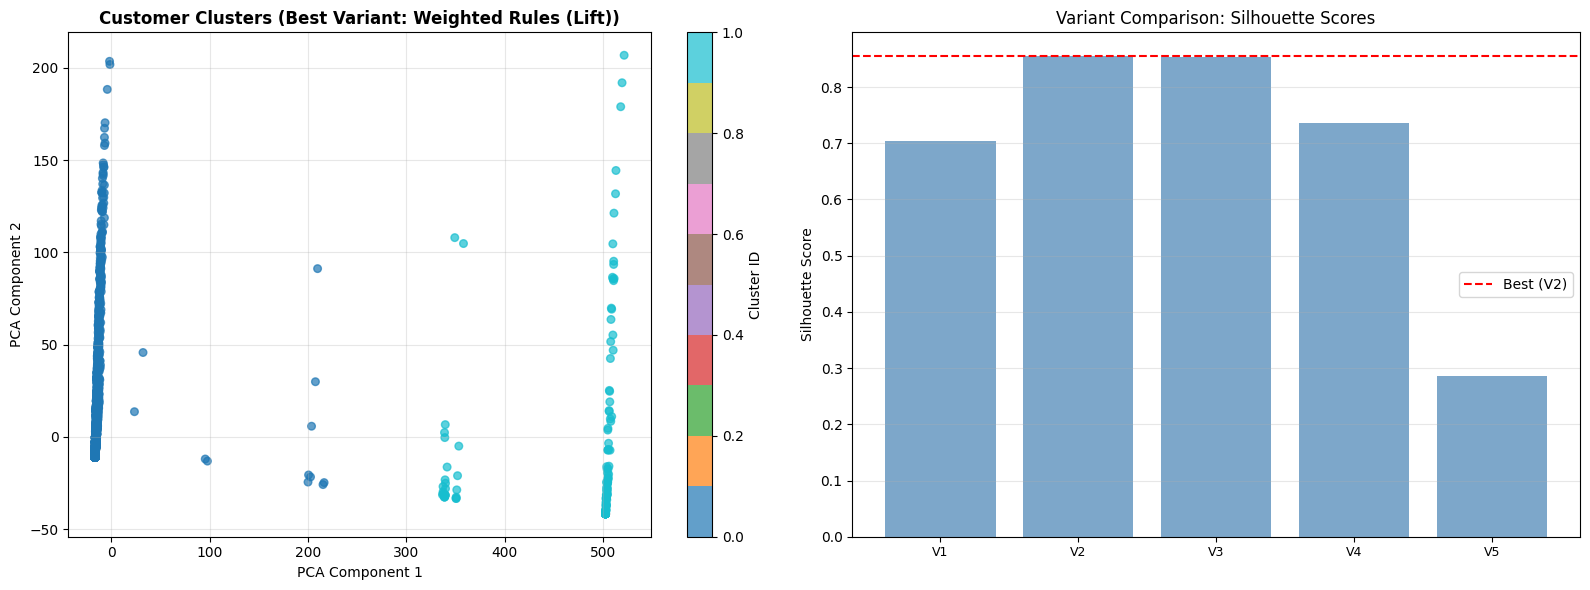


Visualization shows:
  - PCA 2D projection of 3921 customers
  - Best variant silhouette: 0.8546


In [11]:
if PLOT_2D:
    Z = clusterer.project_2d(X_best, method=PROJECTION_METHOD, random_state=RANDOM_STATE)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Clusters colored by label
    ax = axes[0]
    scatter1 = ax.scatter(Z[:,0], Z[:,1], c=labels_best, s=30, cmap='tab10', alpha=0.7)
    ax.set_title(f'Customer Clusters (Best Variant: {best_variant["Variant"]})', fontsize=12, fontweight='bold')
    ax.set_xlabel(f'{PROJECTION_METHOD.upper()} Component 1')
    ax.set_ylabel(f'{PROJECTION_METHOD.upper()} Component 2')
    plt.colorbar(scatter1, ax=ax, label='Cluster ID')
    ax.grid(alpha=0.3)
    
    # Plot 2: Silhouette score across all variants
    ax = axes[1]
    ax.bar(range(len(comparison_df)), comparison_df['Silhouette'], color='steelblue', alpha=0.7)
    ax.set_xticks(range(len(comparison_df)))
    ax.set_xticklabels([f"V{i+1}" for i in range(len(comparison_df))], fontsize=9)
    ax.set_ylabel('Silhouette Score')
    ax.set_title('Variant Comparison: Silhouette Scores')
    ax.axhline(y=best_variant['Silhouette'], color='red', linestyle='--', label=f"Best (V{best_variant_idx+1})")
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nVisualization shows:")
    print(f"  - {PROJECTION_METHOD.upper()} 2D projection of {len(meta_out)} customers")
    print(f"  - Best variant silhouette: {best_variant['Silhouette']:.4f}")


## Detailed Cluster Profiling & Interpretation

Extract top rules and features per cluster, and prepare detailed cluster profiles for marketing strategy.



In [12]:
# Reload the best variant's rule dataframe for analysis
rules_best = clusterer.load_rules(
    rules_csv_path=RULES_INPUT_PATH,
    top_k=best_variant['Top K Rules'],
    sort_by=SORT_RULES_BY,
)

# Create Customer × Rule activation matrix for the best variant
customer_rule_matrix = clusterer.build_customer_rule_matrix(
    rules_df=rules_best,
    weighting=best_variant['Weighting'],
)
print(f"Customer × Rule matrix shape: {customer_rule_matrix.shape}")

# Function to get top activated rules per cluster
def get_top_rules_for_cluster(cluster_id, meta_out, rules_df, customer_rule_matrix, top_n=10):
    """
    Get the top N rules most frequently satisfied by customers in a cluster.
    Returns both rule strings and their activation statistics.
    """
    cluster_customers = meta_out[meta_out['cluster'] == cluster_id]['CustomerID'].values
    
    # Identify cluster's customers in the rule matrix (assuming same order as meta)
    cluster_mask = meta_out['cluster'] == cluster_id
    cluster_rule_activations = customer_rule_matrix[cluster_mask].mean(axis=0)  # average activation per rule
    
    # Get top rules
    top_rule_indices = np.argsort(-cluster_rule_activations)[:top_n]
    
    result = []
    for idx in top_rule_indices:
        if idx < len(rules_df):
            row = rules_df.iloc[idx]
            result.append({
                'Rule': row.get('rule_text', f"Rule {idx}"),
                'Support': row.get('support', 0),
                'Confidence': row.get('confidence', 0),
                'Lift': row.get('lift', 0),
                'Activation Rate': cluster_rule_activations[idx],
            })
    
    return pd.DataFrame(result)

# Create comprehensive cluster profiles
cluster_profiles = []

print("\n" + "=" * 100)
print("CLUSTER PROFILES - TOP 10 RULES PER CLUSTER")
print("=" * 100)

for cluster_id in sorted(meta_out['cluster'].unique()):
    cluster_data = meta_out[meta_out['cluster'] == cluster_id]
    n_customers = len(cluster_data)
    
    profile = {
        'cluster_id': cluster_id,
        'n_customers': n_customers,
        'pct_customers': 100 * n_customers / len(meta_out),
    }
    
    # Add RFM stats if available
    for rfm_col in ['Recency', 'Frequency', 'Monetary']:
        if rfm_col in meta_out.columns:
            profile[f'{rfm_col}_mean'] = cluster_data[rfm_col].mean()
            profile[f'{rfm_col}_median'] = cluster_data[rfm_col].median()
            profile[f'{rfm_col}_std'] = cluster_data[rfm_col].std()
    
    cluster_profiles.append(profile)
    
    # Print cluster info
    print(f"\n[CLUSTER {cluster_id}] - {n_customers} customers ({profile['pct_customers']:.1f}%)")
    
    if 'Recency' in meta_out.columns:
        print(f"  Recency (days):   mean={profile['Recency_mean']:.1f}, median={profile['Recency_median']:.1f}")
        print(f"  Frequency (items): mean={profile['Frequency_mean']:.1f}, median={profile['Frequency_median']:.1f}")
        print(f"  Monetary (£):      mean={profile['Monetary_mean']:.2f}, median={profile['Monetary_median']:.2f}")
    
    print(f"\n  Top 10 Rules (sorted by activation rate in this cluster):")
    top_rules = get_top_rules_for_cluster(cluster_id, meta_out, rules_best, customer_rule_matrix, top_n=10)
    
    if len(top_rules) > 0:
        for idx, row in top_rules.iterrows():
            print(f"    {idx+1}. {row['Rule'][:70]}")
            print(f"       Activation: {row['Activation Rate']:.2%} | Lift: {row['Lift']:.2f} | Confidence: {row['Confidence']:.2%}")
    print()

# Create profile summary dataframe
profile_summary = pd.DataFrame(cluster_profiles)
print("\n" + "=" * 100)
print("CLUSTER PROFILE SUMMARY TABLE")
print("=" * 100)
print(profile_summary.to_string())


Customer × Rule matrix shape: (3921, 200)

CLUSTER PROFILES - TOP 10 RULES PER CLUSTER

[CLUSTER 0] - 3797 customers (96.8%)
  Recency (days):   mean=93.2, median=51.0
  Frequency (items): mean=4.1, median=2.0
  Monetary (£):      mean=1809.82, median=630.84

  Top 10 Rules (sorted by activation rate in this cluster):
    1. Rule 105
       Activation: 246.30% | Lift: 31.92 | Confidence: 54.91%
    2. Rule 139
       Activation: 216.34% | Lift: 27.20 | Confidence: 72.30%
    3. Rule 145
       Activation: 210.74% | Lift: 26.50 | Confidence: 45.58%
    4. Rule 138
       Activation: 209.89% | Lift: 27.20 | Confidence: 76.83%
    5. Rule 95
       Activation: 200.45% | Lift: 34.60 | Confidence: 59.51%
    6. Rule 59
       Activation: 196.76% | Lift: 51.17 | Confidence: 76.95%
    7. Rule 67
       Activation: 193.15% | Lift: 46.42 | Confidence: 71.09%
    8. Rule 110
       Activation: 187.54% | Lift: 30.96 | Confidence: 47.42%
    9. Rule 137
       Activation: 183.75% | Lift: 27.25 | 

## Cluster Naming, Personas & Marketing Strategies

Assign meaningful names to each cluster based on their characteristics and design targeted marketing strategies.



In [13]:
# Define cluster names, personas, and marketing strategies
# Based on RFM analysis and top rules activation

cluster_strategies = {}

# Calculate overall statistics for comparison
overall_recency = meta_out['Recency'].mean() if 'Recency' in meta_out.columns else 0
overall_frequency = meta_out['Frequency'].mean() if 'Frequency' in meta_out.columns else 0
overall_monetary = meta_out['Monetary'].mean() if 'Monetary' in meta_out.columns else 0

print("\n" + "=" * 100)
print("CLUSTER CHARACTERISTICS & MARKETING STRATEGIES")
print("=" * 100)
print(f"\nOverall Averages: Recency={overall_recency:.1f} days, Frequency={overall_frequency:.1f}, Monetary=£{overall_monetary:.2f}")

def classify_cluster(avg_recency, avg_frequency, avg_monetary, n_cust, total_cust, 
                     overall_r, overall_f, overall_m):
    """
    Classify cluster based on RFM characteristics and assign meaningful names.
    """
    pct = 100 * n_cust / total_cust
    
    # High Recency = Dormant (many days since last purchase)
    # Low Recency = Recent purchaser
    # High Frequency = Frequent buyer
    # High Monetary = High spender
    
    is_recent = avg_recency < overall_r * 0.7  # 30% more recent than average
    is_dormant = avg_recency > overall_r * 1.5  # 50% more dormant than average
    is_frequent = avg_frequency > overall_f * 1.3  # 30% more frequent
    is_high_value = avg_monetary > overall_m * 1.5  # 50% higher spending
    is_low_value = avg_monetary < overall_m * 0.5  # 50% lower spending
    is_small_segment = pct < 15  # Less than 15% of total customers
    
    # Classification logic
    if is_high_value and is_frequent and is_recent:
        return (
            "Champions",
            "Khách hàng VIP",
            "Best customers: recent, frequent, high-spending with strong product affinity",
            "VIP Treatment: Exclusive early access, personalized recommendations, premium bundles based on top rules, loyalty rewards program, dedicated customer support"
        )
    elif is_high_value and is_frequent and not is_dormant:
        return (
            "Loyal High-Spenders",
            "Khách trung thành chi tiêu cao",
            "Loyal customers with high spending and consistent purchase patterns",
            "Cross-sell Focus: Recommend complementary products from association rules, upsell premium variants, tiered loyalty benefits, member-exclusive events"
        )
    elif is_frequent and not is_high_value:
        return (
            "Frequent Browsers",
            "Khách mua thường xuyên",
            "Regular customers who buy often but with lower basket value",
            "Basket Enhancement: Bundle offers from top rules, volume discounts, free shipping thresholds, product education to increase basket size"
        )
    elif is_high_value and not is_frequent:
        return (
            "Big Spenders",
            "Khách chi tiêu lớn",
            "High-value occasional buyers who make significant purchases",
            "Engagement Campaign: Reactivation emails, premium product launches, exclusive previews, personalized offers based on past high-value purchases"
        )
    elif is_dormant and is_high_value:
        return (
            "At-Risk VIPs",
            "VIP có nguy cơ rời bỏ",
            "Previously high-value customers who haven't purchased recently",
            "Win-Back Urgent: Personalized win-back campaigns, special comeback offers, satisfaction surveys, exclusive re-engagement discounts"
        )
    elif is_dormant:
        return (
            "Hibernating",
            "Khách ngủ đông",
            "Inactive customers who haven't purchased in a long time",
            "Reactivation: Email win-back sequences, special comeback discounts, product updates, low-cost entry offers to re-engage"
        )
    elif is_recent and is_low_value:
        return (
            "New/Exploring",
            "Khách mới/Đang khám phá",
            "Recent customers with low spending, possibly new or exploring",
            "Nurturing: Welcome sequences, first-purchase incentives, product discovery recommendations, educational content about popular bundles"
        )
    else:
        return (
            "Regular Customers",
            "Khách hàng thông thường",
            "Average customers with moderate purchasing behavior",
            "General Engagement: Seasonal promotions, cross-sell based on association rules, loyalty program enrollment, targeted campaigns for rule-based bundles"
        )

for cluster_id in sorted(meta_out['cluster'].unique()):
    cluster_data = meta_out[meta_out['cluster'] == cluster_id]
    n_cust = len(cluster_data)
    
    # Get RFM stats
    avg_recency = cluster_data['Recency'].mean() if 'Recency' in cluster_data.columns else overall_recency
    avg_frequency = cluster_data['Frequency'].mean() if 'Frequency' in cluster_data.columns else overall_frequency
    avg_monetary = cluster_data['Monetary'].mean() if 'Monetary' in cluster_data.columns else overall_monetary
    
    # Get cluster classification
    name_en, name_vi, persona, strategy = classify_cluster(
        avg_recency, avg_frequency, avg_monetary, n_cust, len(meta_out),
        overall_recency, overall_frequency, overall_monetary
    )
    
    # Get top rules for this cluster
    cluster_mask = meta_out['cluster'] == cluster_id
    cluster_rule_activations = customer_rule_matrix[cluster_mask].mean(axis=0)
    top_3_rule_indices = np.argsort(-cluster_rule_activations)[:3]
    top_rules_str = []
    for idx in top_3_rule_indices:
        if idx < len(rules_best):
            rule_text = rules_best.iloc[idx].get('rule_str', f"Rule {idx}")[:60]
            top_rules_str.append(rule_text)
    
    strategy_dict = {
        'cluster_id': cluster_id,
        'name_en': name_en,
        'name_vi': name_vi,
        'n_customers': n_cust,
        'pct_total': 100 * n_cust / len(meta_out),
        'avg_recency': avg_recency,
        'avg_frequency': avg_frequency,
        'avg_monetary': avg_monetary,
        'persona': persona,
        'strategy': strategy,
        'top_rules': " | ".join(top_rules_str[:3]) if top_rules_str else "N/A",
    }
    
    cluster_strategies[cluster_id] = strategy_dict
    
    # Print cluster strategy
    print(f"\n{'='*80}")
    print(f"[CLUSTER {cluster_id}] {name_en} ({name_vi})")
    print(f"{'='*80}")
    print(f"  📊 Size: {n_cust} customers ({100 * n_cust / len(meta_out):.1f}% of total)")
    print(f"  📅 Avg Recency: {avg_recency:.1f} days (overall: {overall_recency:.1f})")
    print(f"  🛒 Avg Frequency: {avg_frequency:.1f} orders (overall: {overall_frequency:.1f})")
    print(f"  💷 Avg Monetary: £{avg_monetary:.2f} (overall: £{overall_monetary:.2f})")
    print(f"\n  👤 Persona: {persona}")
    print(f"\n  🎯 Marketing Strategy:\n     {strategy}")
    if top_rules_str:
        print(f"\n  📦 Top Associated Rules:")
        for i, rule in enumerate(top_rules_str, 1):
            print(f"     {i}. {rule}")

# Create strategy summary dataframe
strategy_summary = pd.DataFrame(list(cluster_strategies.values()))
print("\n" + "=" * 100)
print("STRATEGY SUMMARY TABLE")
print("=" * 100)
display_cols = ['cluster_id', 'name_en', 'name_vi', 'n_customers', 'pct_total', 
                'avg_recency', 'avg_frequency', 'avg_monetary', 'persona']
print(strategy_summary[display_cols].to_string())

# Save strategy summary
strategy_csv = os.path.join(os.path.dirname(OUTPUT_CLUSTER_PATH), "cluster_strategies.csv")
strategy_summary.to_csv(strategy_csv, index=False)
print(f"\n✅ Saved strategy summary: {strategy_csv}")


CLUSTER CHARACTERISTICS & MARKETING STRATEGIES

Overall Averages: Recency=92.2 days, Frequency=4.6, Monetary=£2301.77

[CLUSTER 0] Regular Customers (Khách hàng thông thường)
  📊 Size: 3797 customers (96.8% of total)
  📅 Avg Recency: 93.2 days (overall: 92.2)
  🛒 Avg Frequency: 4.1 orders (overall: 4.6)
  💷 Avg Monetary: £1809.82 (overall: £2301.77)

  👤 Persona: Average customers with moderate purchasing behavior

  🎯 Marketing Strategy:
     General Engagement: Seasonal promotions, cross-sell based on association rules, loyalty program enrollment, targeted campaigns for rule-based bundles

  📦 Top Associated Rules:
     1. WOODEN STAR CHRISTMAS SCANDINAVIAN → WOODEN TREE CHRISTMAS S
     2. WOODEN HEART CHRISTMAS SCANDINAVIAN → WOODEN STAR CHRISTMAS 
     3. WOODEN HEART CHRISTMAS SCANDINAVIAN → WOODEN TREE CHRISTMAS 

[CLUSTER 1] Champions (Khách hàng VIP)
  📊 Size: 124 customers (3.2% of total)
  📅 Avg Recency: 60.5 days (overall: 92.2)
  🛒 Avg Frequency: 21.3 orders (overall: 4.6